# Operaciones del Perceptrón Multicapa 

Empecemos por importar las libr's y definamos las dimensiones.$ \\ $
**P** instancias de datos.$ \\ $
2 variables de entrada.$ \\ $
1 objetivo.$ \\ $
De momento tendremos una sola capa oculta con 3 unidades. $ \\ $ 
**Si** (input)
**Sh** (hidden)
**So** (output)

In [1]:
import numpy as np 
from matplotlib import pyplot as mpl, cm 
np.random.seed(123)
P = 100 
Si = 2 
Sh = 3
So = 1 

Los datos van consistir en **valores generados a azar para la entrada** y el **signo del producto** de estas
variables como **objetivo**, de manera que se obtiene un problema que es claramente no linealmente
separable.

In [2]:
x = np.random.uniform(-5, 5,(P,Si)) 
z = np.sign( np.prod(x, axis=1).reshape((P,So)) )

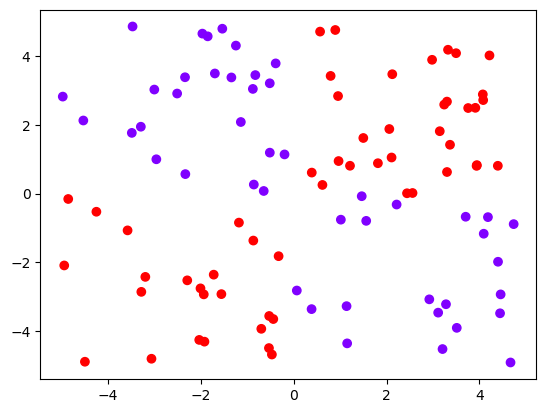

In [16]:
mpl.scatter( x[:,0], x[:,1], c=z.flatten(), cmap=cm.rainbow)
mpl.show()

$Y_k$ <- valores de activacion de las unidades. 
$W_k$ <- valores de los pesos de las conexiones.

**Obs: Poner dim adicional para los umbrales**

In [20]:
Y_0 = np.zeros((P,Si+1)) # x 

W_1 = np.random.normal(0,0.5,(Si + 1,Sh))
W_2 = np.random.normal(0,0.5,(Sh + 1,So))

Y_1 = np.zeros((P,Sh+1)) # x @ W_1
Y_2 = np.zeros((P,So))

W = [W_1,W_2]

Definimos 2 f_aux, una para agregar los umbrales (ie conc. array1 en la col), y otra para quitar los umbrales. 

In [3]:
def bias_add(V): 
    bias = np.ones((len(V),1))
    return np.hstack([V,bias])

def bias_ex(V): 
    return V[:,:-1]

Por el momento vamos a seguir utilizando el metodo de entrenamiento por lotes. 

Debido a que se trata de un modelo de una sola capa escribimos explicitamente las operaciones necesarias: 

$$ Y_0 = X$$ 
$$ Y_1 = s_1(Y_0 \bullet W_1) $$
$$ Y_2 = s_2(Y_1 \bullet W_2) $$

$$ E_2 = Z - Y_2$$
$$ D_2 = E_2 . dY_2 $$ 
derivada de la funcion de activacion 
$$ \Delta W_2 = \eta . (Y^{T}_1 \bullet D_2) $$

$$ E_1 = D_2 \bullet W^{T}_2 $$
$$ D_1 = E_1 . dY_1 $$
$$ \Delta W_1 = \eta (Y^{T}_0 \bullet D_1) $$

Algoritmo de entrenamiento: 

Repetir mientras **error > error maximo** and **epoca < epoca maxima** 

   Calcular la activacion para las capas $Y_0, Y_1$ y $Y_2$.
   
   Calcular para la capa de salida (2) el error.
   
   Calcular las correcciones a los pesos en la capa de salida (∆W2).
   
   Calcular para la capa oculta (1) el error.
   
   Calcular las correcciones a los pesos en la capa oculta (∆W1).
   
   Calcular las correcciones a los pesos en la capa oculta (∆W1 )    

Declaramos coef. de entrenamiento, y variables para guardar el error y epoca 

In [18]:
eta = 0.1 
error = 1 
epoch = 0 

Hacemos la propagacion de los estimos hace "adelante", calculando los niveles de activacion de las neuronas en cada capa. 


In [21]:
# Al hacerlo de esta forma hace que los valores resultantes del mim. der 
# se pasen por copia a Y.. ([:])
Y_0[:] = bias_add(x)
Y_1[:] = bias_add( np.tanh( Y_0 @ W_1) )
Y_2[:] = np.tanh(Y_1 @ W_2)

Como $$ f'(x) = 1 - f^{2}(x) $$ para la funcion de transferencia, que suponemos que es la sigmoidea tangencial. 

Calculamos $$ \Delta W_2$$

In [22]:
E2 = z - Y_2 
dY_2 = 1 - np.square(Y_2)
D2 = E2 * dY_2 

In [24]:
dW_2 = (Y_1).T @ D2 

Correcciones de la capa oculta: 
* Los errores van a ser retro-propagados de la capa posterior. 
* Se debe eliminar la dimension extra en los daltas conrrespondiente a la unidad umbral 

In [21]:
E1 = D2 @ (W_2).T 
dY_1 = 1 - np.square(Y_1)
D1 = bias_ex(E1*dY_1)
dW_1 = (Y_0).T @ D1

Actualizamos los pesos en las correcciones y calculamos la estimacion del error

In [87]:
W_1 += eta * dW_1
W_2 += eta * dW_2
error = np.mean(np.square(E2))

Ponemos todo en funciones, para simplificar cada paso en el entrenamiento, y de paso hacemos que ande en general, ie para una arbitraria cantidad de capas ocultas. 

In [4]:
def activacion(x,W): 
    Y = []
    y = x
    for i in range(len(W)): 
        Y.append(bias_add(y))
        y = np.tanh( Y[i] @ W[i] )
    Y.append(y)
    return Y
def correccion(Y,z,eta): 
    dW = []
    D = []
    n = len(Y)
    E = z - Y[n-1]
    error = np.mean(np.square(z - Y[n-1]))
    dY = 1 - np.square(Y[n-1])
    D.insert(0,E*dY)
    k = n-2
    while k != -1:
        dW.insert(0,eta * (Y[k]).T @ D[0])
        E = D[0] @ (W[k]).T
        dY = 1 - np.square(Y[k])
        D.insert(0,bias_ex(E*dY))
        k-=1
    return [dW,error]

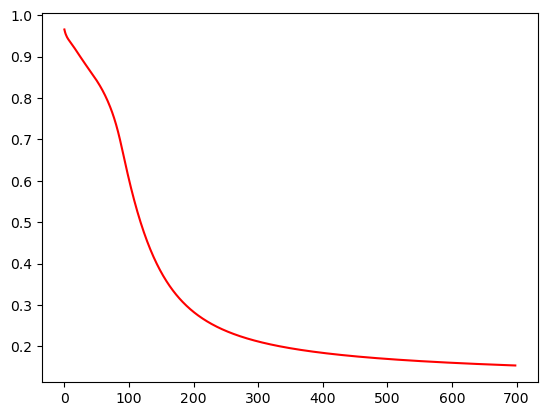

In [12]:
W_1 = np.random.normal(0,0.5,(3,3))
W_2 = np.random.normal(0,0.5,(4,1))
W = [W_1,W_2]
eta = 0.001 
error = 1 
epoch = 0  
epoch_max = 699
er_min = 1e-5
Ers = []
while (error > er_min) and (epoch < epoch_max): 
    Y = activacion(x,W)
    dW,error = correccion(Y,z,eta)
    # Adatacion 
    for i in range(len(W)): 
        W[i] += dW[i]
    # Estimacion 
    Ers.append(error)
    epoch += 1
mpl.plot(Ers,'r')
mpl.show()

In [13]:
Y_final = activacion(x,W)
print(Y_final[len(Y_final)-1][:5])
print(z[:5])

[[-0.90208349]
 [-0.71081212]
 [-0.69602689]
 [ 0.94207813]
 [ 0.75510804]]
[[-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]]


## Entrenamiento estocastico

Si al calcular las correcciones usamos una instancia por vez, esto se llama aprendizaje incremental (incremental/on-line), y aquí recorrer las instancias en un orden aleatorio suele mejorar las posibilidades de converger a una buena solución. En particular, elegir los datos al azar
individualmente es lo que se conoce como Stochastic Gradient Descent (SGD)

In [14]:
W_1 = np.random.normal(0,0.5,(3,3))
W_2 = np.random.normal(0,0.5,(4,1))
W = [W_1,W_2]
eta = 0.01 
epoch = 1
epoch_max = 999
er_min = 1e-3
Ers = []
stocastic = np.random.permutation(P)
while (epoch < epoch_max): 
    e = 0
    for h in stocastic:
        Xh = x[h:h+1]
        Zh = z[h:h+1]
        Yh = activacion(Xh,W)
        dW,error = backpropagation(Yh,Zh,eta)
        # Adatacion 
        for i in range(len(W)): 
            W[i] += dW[i]
        # Estimacion 
        e += error
    e /= P
    Ers.append(e)
    epoch += 1
mpl.plot(Ers,'r')
mpl.show()
print(Ers[epoch-1])

Otra solucion quizas sea una combinacion entra ambas tecnicas, llamada *mini-batch*, donde se eligen al azar porciones realtivamente chicas de los datos y se los utiliza para calcular las correcciones a los pesos. 

In [ ]:
W_1 = np.random.normal(0,0.5,(3,3))
W_2 = np.random.normal(0,0.5,(4,1))
W = [W_1,W_2]
eta = 0.05 
B = 10
epoch = 1
epoch_max = 999
er_min = 1e-3
Ers = []
stocastic = np.random.permutation(P)
while (epoch < epoch_max): 
    e = 0
    for h in range(0,P,B):
        batch = stocastic[h:h+B]
        Xh = []
        Zh = []
        for i in batch: 
            Xh.append(x[i])
            Zh.append(z[i])
        Yh = activacion(Xh,W)
        dW,error = backpropagation(Yh,Zh,eta)
        # Adatacion 
        for i in range(len(W)): 
            W[i] += dW[i]
        # Estimacion 
        e += error
    Ers.append(e/P)
    epoch += 1
mpl.plot(Ers,'r')
mpl.show()
print(min(Ers))